# Data transformation test

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 

from numpy.lib.stride_tricks import sliding_window_view

import tensorflow as tf
from tensorflow import keras

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from IPython.display import display

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
df = pd.read_csv('GOOGL.csv')
df.Date = pd.to_numeric(pd.to_datetime(df.Date, format='%Y-%m-%d'))
df.pop('Adj Close')

0         50.220219
1         54.209209
2         54.754753
3         52.487488
4         53.053055
           ...     
4426    2722.510010
4427    2722.030029
4428    2797.360107
4429    2765.510010
4430    2831.439941
Name: Adj Close, Length: 4431, dtype: float64

In [6]:
df.describe()

,Date,Open,High,Low,Close,Volume
count,4.431000e+03,4431.000000,4431.000000,4431.000000,4431.000000,4.431000e+03
mean,1.370505e+18,693.087345,699.735595,686.078751,693.097367,6.444992e+06
std,1.603781e+17,645.118799,651.331215,638.579488,645.187806,7.690351e+06
min,1.092874e+18,49.644646,50.920921,48.028027,50.055054,4.656000e+05
25%,1.231762e+18,248.558563,250.853355,245.813309,248.415916,1.695600e+06
50%,1.370563e+18,434.924927,437.887878,432.687683,435.330322,3.778418e+06
75%,1.509192e+18,1007.364990,1020.649994,997.274994,1007.790008,8.002390e+06
max,1.648080e+18,3025.000000,3030.929932,2977.979980,2996.770020,8.215117e+07


## Setup

In [7]:
def prepare_data_partial(data, scaler, window_size=50, train=True):
    scaled_data = scaler.fit_transform(data) if train else scaler.transform(data)
    input_data = sliding_window_view(scaled_data, window_size, axis=0).transpose(0,2,1)[:-1]
    output_data = scaled_data[window_size:,1]
    output_data = np.reshape(output_data, (-1,1))
    return (input_data, output_data)
    
def prepare_data(data, scaler, split=0.9, window_size=50):
    train_size = int(split*len(data))
    
    train = data[:train_size]
    test = data[train_size:]
    
    preped_train = prepare_data_partial(train, scaler, window_size, True)
    preped_test = prepare_data_partial(test, scaler, window_size, True)
    return (preped_train, preped_test)

In [8]:
mae = keras.losses.MeanAbsoluteError()
mse = keras.losses.MeanSquaredError()
hub = keras.losses.Huber()
hin = keras.losses.Hinge()

def eval_model(model, history, loss='mae', optimizer='AdamW'):
    y_pred = model.predict(X_test)
    res = pd.DataFrame({'Test': y_test.ravel(), 'Predicted': y_pred.ravel()})
    sns.lineplot(res, dashes=False)
    plt.show()
    
    pd.DataFrame(history.history).plot()
    plt.show()

    #print(f"Best val loss: {min(history.history['val_loss'])}")
    
    return {
        'best_val_loss': min(history.history['val_loss']),
        'loss_method': loss,
        'optimizer': optimizer,
        'mae': mae(y_test, y_pred).numpy(),
        'mse': mse(y_test, y_pred).numpy(),
        'huber': hub(y_test, y_pred).numpy(),
        'hinge': hin(y_test, y_pred).numpy(),
    }

def res_to_table(result):
    return pd.DataFrame.from_dict(result, orient='index').T

In [9]:
results = {}

# Percent transform

In [10]:
scaler = MinMaxScaler((-1,1))
data_percent = df.copy()
data_percent.High = df.High / df.Open
data_percent.Low = df.Low / df.Open
data_percent.Close = df.Close / df.Open
data_percent.Volume = np.log(df.Volume)
((X_train, y_train), (X_test, y_test)) = prepare_data(data_percent, scaler)

In [11]:
data_percent

,Date,Open,High,Low,Close,Volume
0,1092873600000000000,50.050049,1.040600,0.959600,1.003400,17.614569
1,1092960000000000000,50.555557,1.079893,0.994951,1.072270,16.943776
2,1093219200000000000,55.430431,1.024650,0.984650,0.987810,16.720011
3,1093305600000000000,55.675674,1.003236,0.931050,0.942736,16.539915
4,1093392000000000000,52.532532,1.028963,0.989710,1.009909,16.033474
...,...,...,...,...,...,...
4426,1647561600000000000,2668.489990,1.021132,0.991261,1.020244,14.614413
4427,1647820800000000000,2723.270020,1.006511,0.984790,0.999545,14.109373
4428,1647907200000000000,2722.030029,1.036359,1.000000,1.027674,14.389198
4429,1647993600000000000,2774.050049,1.006388,0.993746,0.996921,14.044795


## SimpleRNN

### 1 SimpleRNN sloj

In [13]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.SimpleRNN(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 300
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2850      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2901 (11.33 KB)
Trainable params: 2901 (11.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 1s 20ms/step - loss: 0.2931 - val_loss: 0.0243 - lr: 0.0010
Epoch 2/300
25/25 [==============================] - 0s 15ms/step - loss: 0.0183 - val_loss: 0.0189 - lr: 0.0010
Epoch 3/300
25/25 [==============================] - 0s 20ms/step - loss: 0.0080 - val_loss: 0.0131 - lr: 0.0010
Epoch 4/300
25/25 [==============================] - 0s 18ms/step - loss: 0.0

13/13 [==============================] - 0s 6ms/step


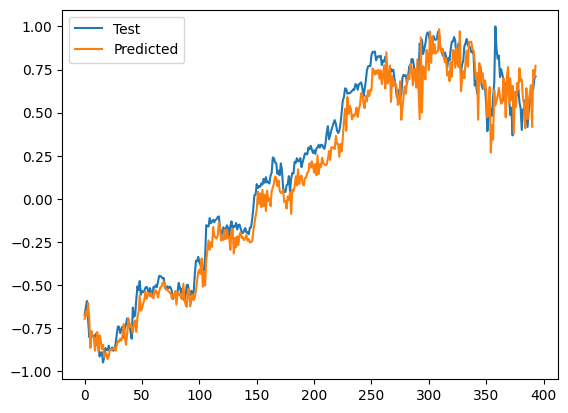

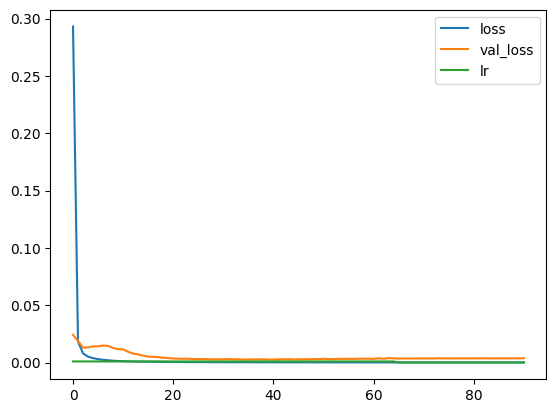

,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.002627,mae,AdamW,0.089075,0.01244,0.00622,0.65816


In [14]:
results['SimpleRNN_1layer'] = eval_model(model, history)
res_to_table(results['SimpleRNN_1layer'])

In [15]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.SimpleRNN(50, return_sequences=True),
    keras.layers.SimpleRNN(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 300
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            2850      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7951 (31.06 KB)
Trainable params: 7951 (31.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 3s 48ms/step - loss: 0.0623 - val_loss: 0.0627 - lr: 0.0010
Epoch 2/300
25/25 [==============================] - 1s 44ms/step - loss: 0.0056 - val_loss: 0.0199 - lr: 0.0010
Epoch 3/300
25/25 [==============================] - 1s 44

13/13 [==============================] - 0s 7ms/step


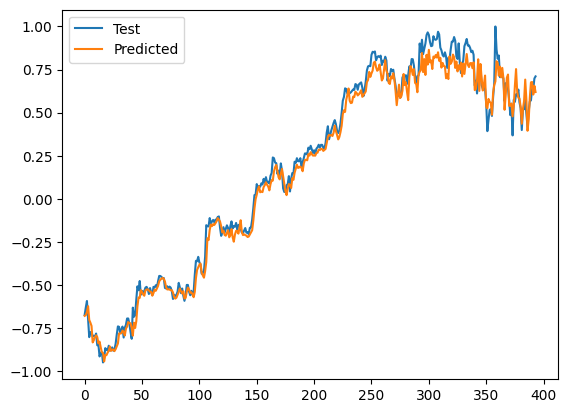

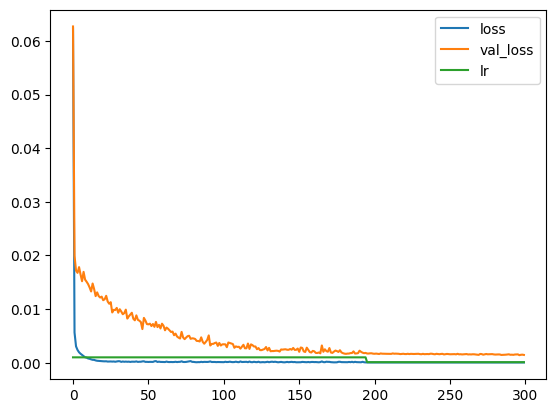

,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.001402,mae,AdamW,0.04829,0.003946,0.001973,0.653627


In [16]:
results['SimpleRNN_2layer'] = eval_model(model, history)
res_to_table(results['SimpleRNN_2layer'])

## LSTM

In [17]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 800
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11400     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11451 (44.73 KB)
Trainable params: 11451 (44.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/800
25/25 [==============================] - 2s 17ms/step - loss: 0.2350 - val_loss: 0.3761 - lr: 0.0010
Epoch 2/800
25/25 [==============================] - 0s 4ms/step - loss: 0.0118 - val_loss: 0.1708 - lr: 0.0010
Epoch 3/800
25/25 [==============================] - 0s 4ms/step - loss: 0.0070 - val_loss: 0.1303 - lr: 0.0010
Epoch 4/800
25/25 [==============================] - 0s 7ms/step - loss: 0.00

13/13 [==============================] - 0s 1ms/step


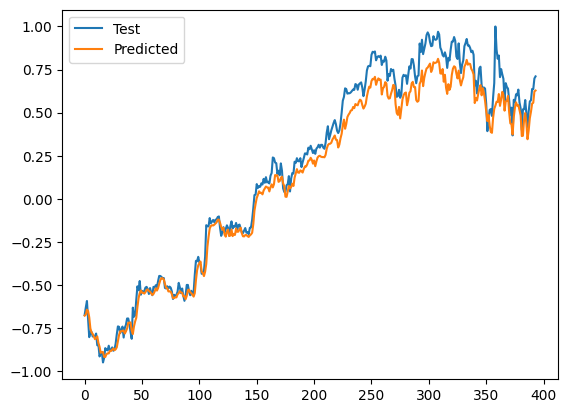

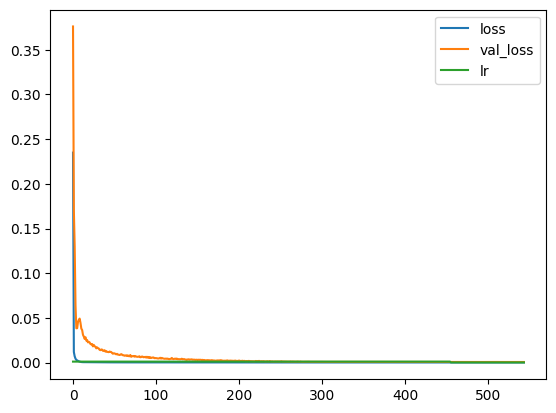

,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.000526,mae,AdamW,0.07649,0.009196,0.004598,0.678301


In [18]:
results['LSTM_1layer'] = eval_model(model, history)
res_to_table(results['LSTM_1layer'])

### 2 LSTM sloja

In [19]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 800
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50, 50)            11400     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31651 (123.64 KB)
Trainable params: 31651 (123.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/800
25/25 [==============================] - 3s 28ms/step - loss: 0.0937 - val_loss: 0.0838 - lr: 0.0010
Epoch 2/800
25/25 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0519 - lr: 0.0010
Epoch 3/800
25/25 [==============================] - 0s

13/13 [==============================] - 1s 2ms/step


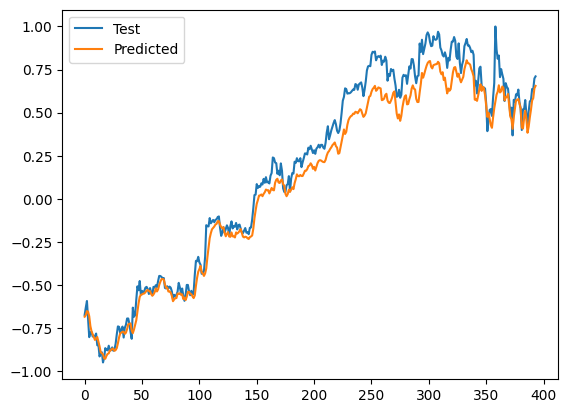

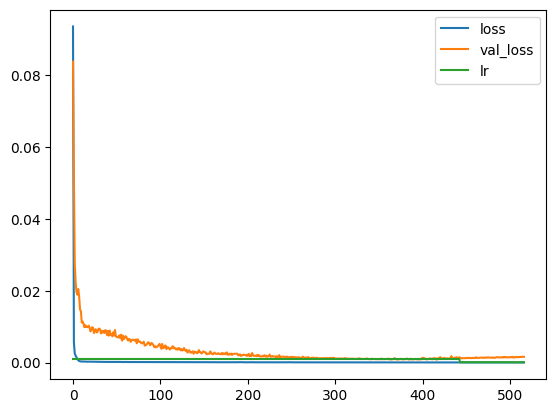

,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.000814,mae,AdamW,0.087696,0.011847,0.005923,0.681059


In [20]:
results['LSTM_2layer'] = eval_model(model, history)
res_to_table(results['LSTM_2layer'])

## GRU

In [22]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.GRU(50),
    keras.layers.Dense(1),
])

epochs = 1000
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/1000
25/25 [==============================] - 2s 14ms/step - loss: 0.1883 - val_loss: 0.1991 - lr: 0.0010
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.1131 - lr: 0.0010
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.1083 - lr: 0.0010
Epoch 4/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0884 - lr: 0.0010
Epoch 5/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0696 - lr: 0.0010
Epoch 6/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0545 - lr: 0.0010
Epoch 7/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0389 - lr: 0.0010
Epoch 8/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0280 - lr: 0.0010
Epoch 9/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.

13/13 [==============================] - 0s 1ms/step


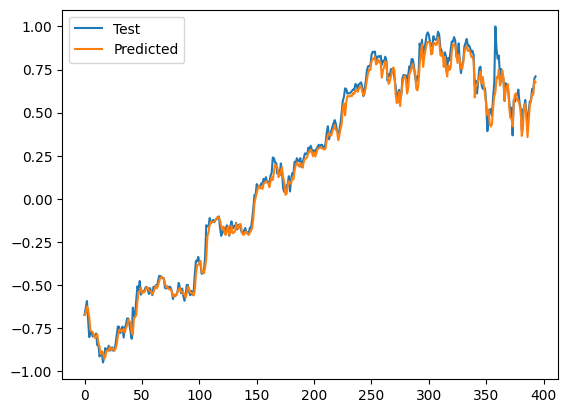

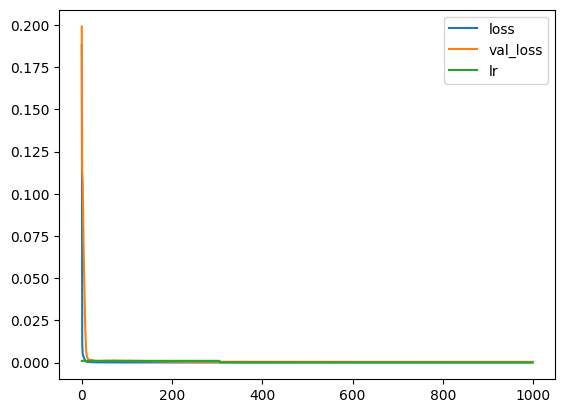

,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.000394,mae,AdamW,0.031728,0.002035,0.001017,0.649689


In [23]:
results['GRU_1layer'] = eval_model(model, history)
res_to_table(results['GRU_1layer'])

Bolji validation loss, medjutim gori rezultati na test setu...

### 2 GRU sloja

In [24]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.GRU(50, return_sequences=True),
    keras.layers.GRU(50),
    keras.layers.Dense(1),
])

epochs = 1000
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/1000
25/25 [==============================] - 3s 24ms/step - loss: 0.0217 - val_loss: 0.1103 - lr: 0.0010
Epoch 2/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.0254 - lr: 0.0010
Epoch 3/1000
25/25 [==============================] - 0s 7ms/step - loss: 6.9356e-04 - val_loss: 0.0040 - lr: 0.0010
Epoch 4/1000
25/25 [==============================] - 0s 7ms/step - loss: 2.2228e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 5/1000
25/25 [==============================] - 0s 7ms/step - loss: 1.8012e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 6/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.5373e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 7/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.3864e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 8/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.2583e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 9/1000
25/25 [==============================] - 0s 6ms/step - los

13/13 [==============================] - 0s 2ms/step


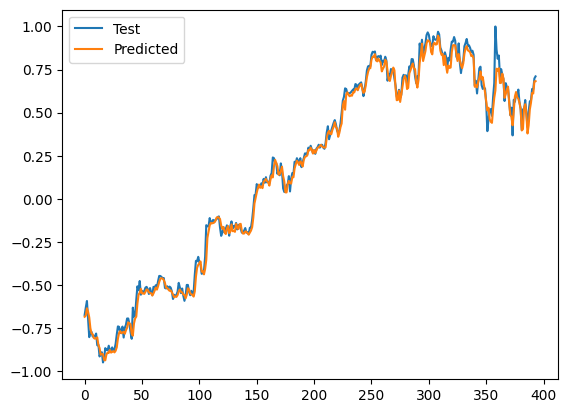

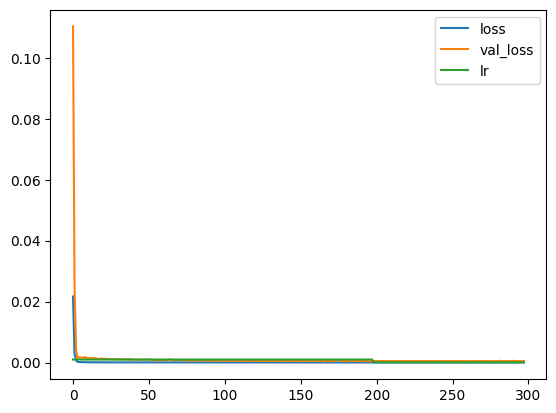

,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.000423,mae,AdamW,0.028984,0.001797,0.000898,0.645324


In [25]:
results['GRU_2layer'] = eval_model(model, history)
res_to_table(results['GRU_2layer'])

## Rezultati

In [26]:
res = res_to_table(results).T.reset_index(names='type')
res

,type,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,SimpleRNN_1layer,0.002627,mae,AdamW,0.089075,0.01244,0.00622,0.65816
1,SimpleRNN_2layer,0.001402,mae,AdamW,0.04829,0.003946,0.001973,0.653627
2,LSTM_1layer,0.000526,mae,AdamW,0.07649,0.009196,0.004598,0.678301
3,LSTM_2layer,0.000814,mae,AdamW,0.087696,0.011847,0.005923,0.681059
4,GRU_1layer,0.000394,mae,AdamW,0.031728,0.002035,0.001017,0.649689
5,GRU_2layer,0.000423,mae,AdamW,0.028984,0.001797,0.000898,0.645324


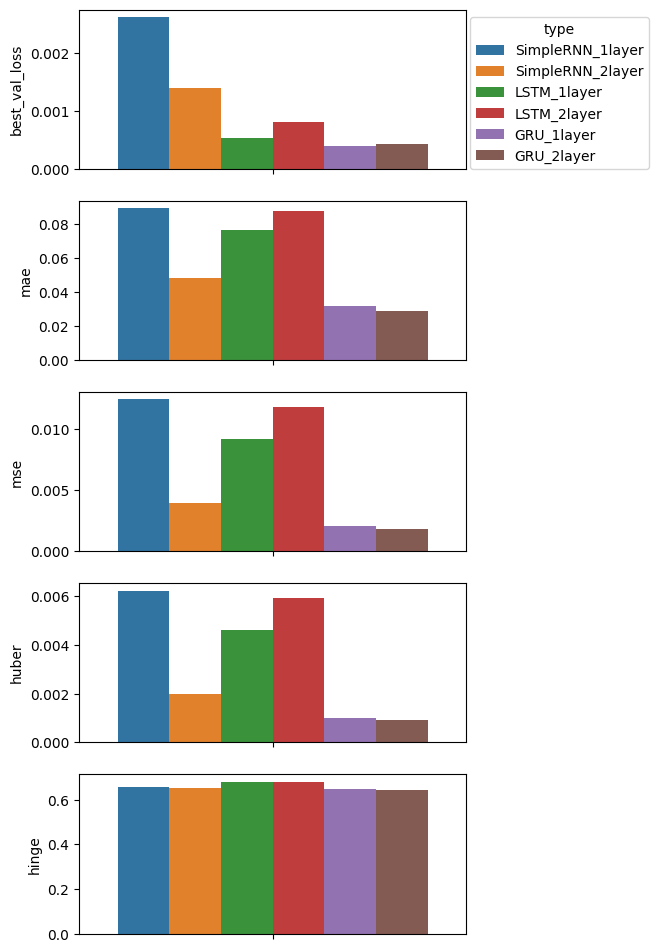

In [27]:
fig = plt.figure(figsize=(5,12))
axs = fig.subplots(nrows=5)
for i, col in enumerate(['best_val_loss', 'mae', 'mse', 'huber', 'hinge']):
    if i == 0:
        sns.move_legend(sns.barplot(res, hue='type', y=col, ax=axs[i], legend=True), (1.01,0))
    else:
        sns.barplot(res, hue='type', y=col, ax=axs[i], legend=False)

Gori rezultati u gotovo svim slucajevima, sem za 2 layer RNN.
Odbacujemo transformaciju nadalje.

# Log transform

In [30]:
scaler = MinMaxScaler((-1,1))
data_log = np.log(df.copy())
((X_train, y_train), (X_test, y_test)) = prepare_data(data_percent, scaler)

## SimpleRNN

### 1 SimpleRNN sloj

In [31]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.SimpleRNN(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 300
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 50)                2850      
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2901 (11.33 KB)
Trainable params: 2901 (11.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 1s 21ms/step - loss: 0.0717 - val_loss: 0.0772 - lr: 0.0010
Epoch 2/300
25/25 [==============================] - 0s 15ms/step - loss: 0.0093 - val_loss: 0.0257 - lr: 0.0010
Epoch 3/300
25/25 [==============================] - 0s 15ms/step - loss: 0.0052 - val_loss: 0.0189 - lr: 0.0010
Epoch 4/300
25/25 [==============================] - 0s 16ms/step - loss: 0.0

13/13 [==============================] - 0s 4ms/step


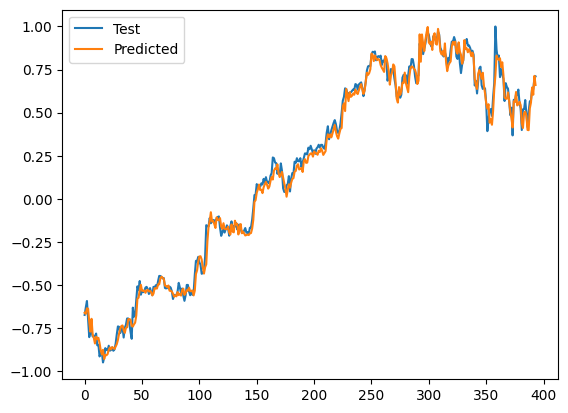

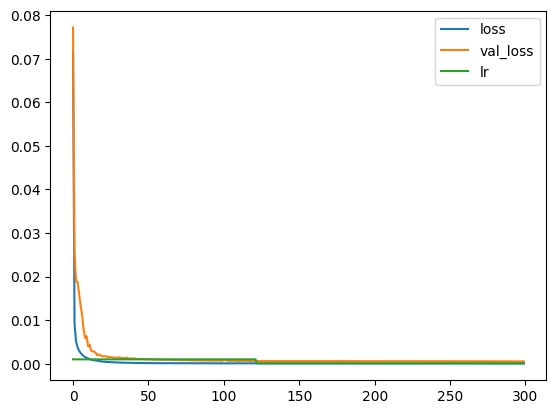

,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.000533,mae,AdamW,0.033529,0.001992,0.000996,0.643434


In [32]:
results['SimpleRNN_1layer'] = eval_model(model, history)
res_to_table(results['SimpleRNN_1layer'])

In [39]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.SimpleRNN(50, return_sequences=True),
    keras.layers.SimpleRNN(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 300
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 50, 50)            2850      
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 7951 (31.06 KB)
Trainable params: 7951 (31.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 3s 53ms/step - loss: 0.1131 - val_loss: 0.0163 - lr: 0.0010
Epoch 2/300
25/25 [==============================] - 1s 42ms/step - loss: 0.0038 - val_loss: 0.0166 - lr: 0.0010
Epoch 3/300
25/25 [==============================] - 1s 4

13/13 [==============================] - 0s 7ms/step


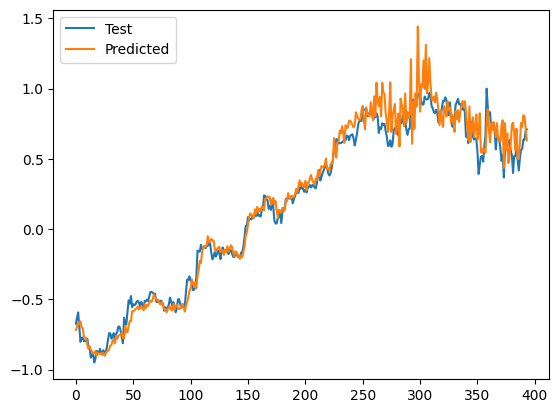

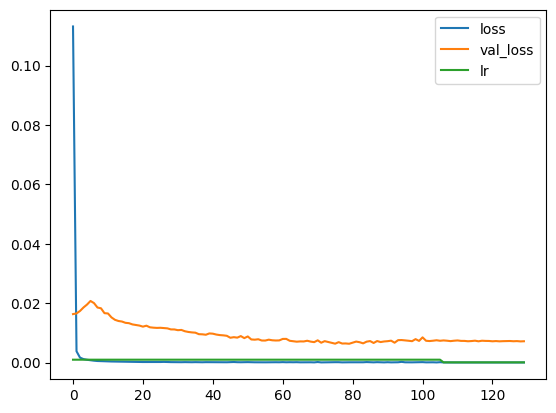

,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.006365,mae,AdamW,0.069851,0.010054,0.005027,0.618724


In [40]:
results['SimpleRNN_2layer'] = eval_model(model, history)
res_to_table(results['SimpleRNN_2layer'])

## LSTM

In [41]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 800
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                11400     
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11451 (44.73 KB)
Trainable params: 11451 (44.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/800
25/25 [==============================] - 2s 16ms/step - loss: 0.1341 - val_loss: 0.1739 - lr: 0.0010
Epoch 2/800
25/25 [==============================] - 0s 5ms/step - loss: 0.0097 - val_loss: 0.1472 - lr: 0.0010
Epoch 3/800
25/25 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0904 - lr: 0.0010
Epoch 4/800
25/25 [==============================] - 0s 5ms/step - loss: 0.0

13/13 [==============================] - 0s 2ms/step


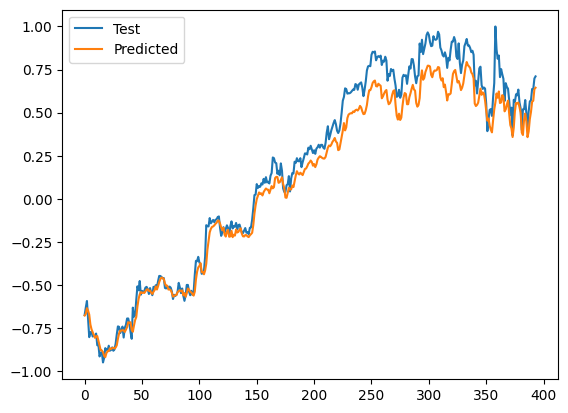

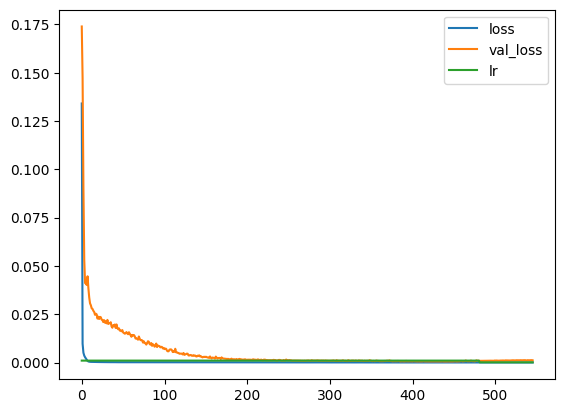

,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.000563,mae,AdamW,0.086429,0.011836,0.005918,0.686261


In [42]:
results['LSTM_1layer'] = eval_model(model, history)
res_to_table(results['LSTM_1layer'])

### 2 LSTM sloja

In [43]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 800
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 50)            11400     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 31651 (123.64 KB)
Trainable params: 31651 (123.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/800
25/25 [==============================] - 3s 28ms/step - loss: 0.0462 - val_loss: 0.1533 - lr: 0.0010
Epoch 2/800
25/25 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0631 - lr: 0.0010
Epoch 3/800
25/25 [==============================] - 0

13/13 [==============================] - 0s 2ms/step


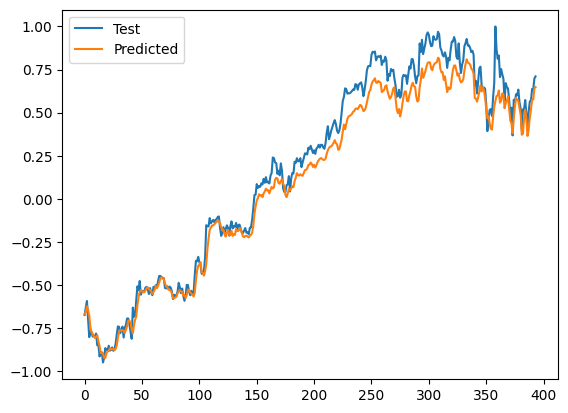

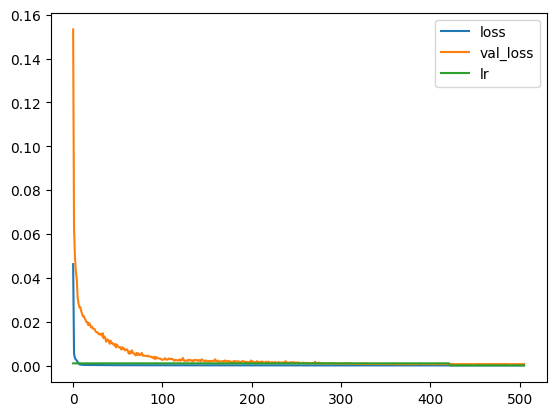

,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.000572,mae,AdamW,0.079027,0.009721,0.00486,0.679872


In [44]:
results['LSTM_2layer'] = eval_model(model, history)
res_to_table(results['LSTM_2layer'])

## GRU

In [45]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.GRU(50),
    keras.layers.Dense(1),
])

epochs = 1000
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/1000
25/25 [==============================] - 2s 15ms/step - loss: 0.0607 - val_loss: 0.1136 - lr: 0.0010
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.1198 - lr: 0.0010
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0814 - lr: 0.0010
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0577 - lr: 0.0010
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0318 - lr: 0.0010
Epoch 6/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0147 - lr: 0.0010
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 6.3544e-04 - val_loss: 0.0063 - lr: 0.0010
Epoch 8/1000
25/25 [==============================] - 0s 5ms/step - loss: 3.8102e-04 - val_loss: 0.0029 - lr: 0.0010
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 3.0240e-04 - 

13/13 [==============================] - 0s 1ms/step


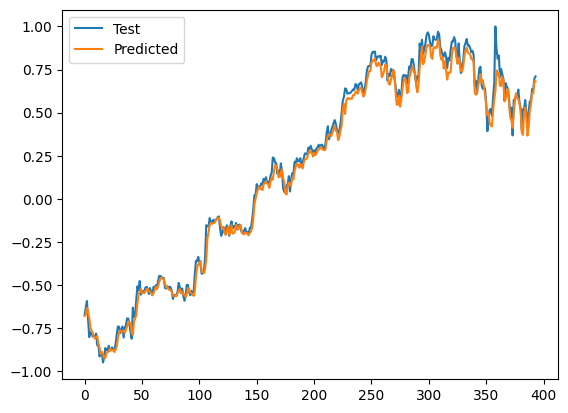

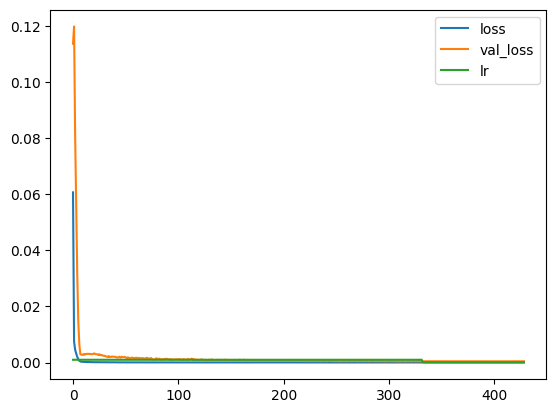

,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.00043,mae,AdamW,0.036768,0.002463,0.001231,0.652931


In [46]:
results['GRU_1layer'] = eval_model(model, history)
res_to_table(results['GRU_1layer'])

Bolji validation loss, medjutim gori rezultati na test setu...

### 2 GRU sloja

In [47]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.GRU(50, return_sequences=True),
    keras.layers.GRU(50),
    keras.layers.Dense(1),
])

epochs = 1000
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/1000
25/25 [==============================] - 3s 24ms/step - loss: 0.1133 - val_loss: 0.1184 - lr: 0.0010
Epoch 2/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.1336 - lr: 0.0010
Epoch 3/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0050 - val_loss: 0.0748 - lr: 0.0010
Epoch 4/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0358 - lr: 0.0010
Epoch 5/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0130 - lr: 0.0010
Epoch 6/1000
25/25 [==============================] - 0s 8ms/step - loss: 6.6857e-04 - val_loss: 0.0051 - lr: 0.0010
Epoch 7/1000
25/25 [==============================] - 0s 7ms/step - loss: 4.3567e-04 - val_loss: 0.0027 - lr: 0.0010
Epoch 8/1000
25/25 [==============================] - 0s 10ms/step - loss: 3.2263e-04 - val_loss: 0.0027 - lr: 0.0010
Epoch 9/1000
25/25 [==============================] - 0s 7ms/step - loss: 2.6263e-

13/13 [==============================] - 0s 2ms/step


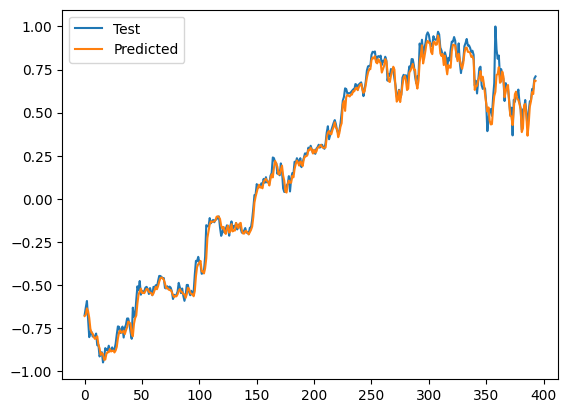

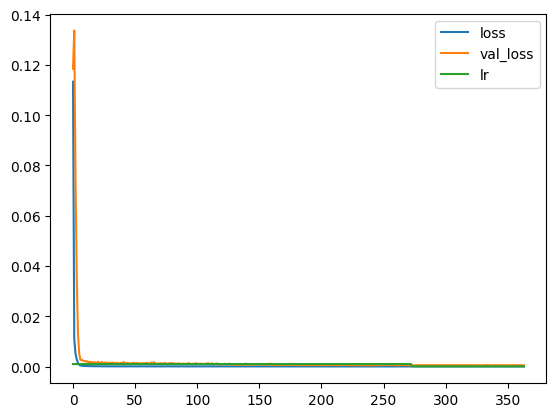

,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.000457,mae,AdamW,0.029297,0.001839,0.00092,0.646262


In [48]:
results['GRU_2layer'] = eval_model(model, history)
res_to_table(results['GRU_2layer'])

## Rezultati

In [49]:
res = res_to_table(results).T.reset_index(names='type')
res

,type,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,SimpleRNN_1layer,0.000533,mae,AdamW,0.033529,0.001992,0.000996,0.643434
1,SimpleRNN_2layer,0.006365,mae,AdamW,0.069851,0.010054,0.005027,0.618724
2,LSTM_1layer,0.000563,mae,AdamW,0.086429,0.011836,0.005918,0.686261
3,LSTM_2layer,0.000572,mae,AdamW,0.079027,0.009721,0.00486,0.679872
4,GRU_1layer,0.00043,mae,AdamW,0.036768,0.002463,0.001231,0.652931
5,GRU_2layer,0.000457,mae,AdamW,0.029297,0.001839,0.00092,0.646262


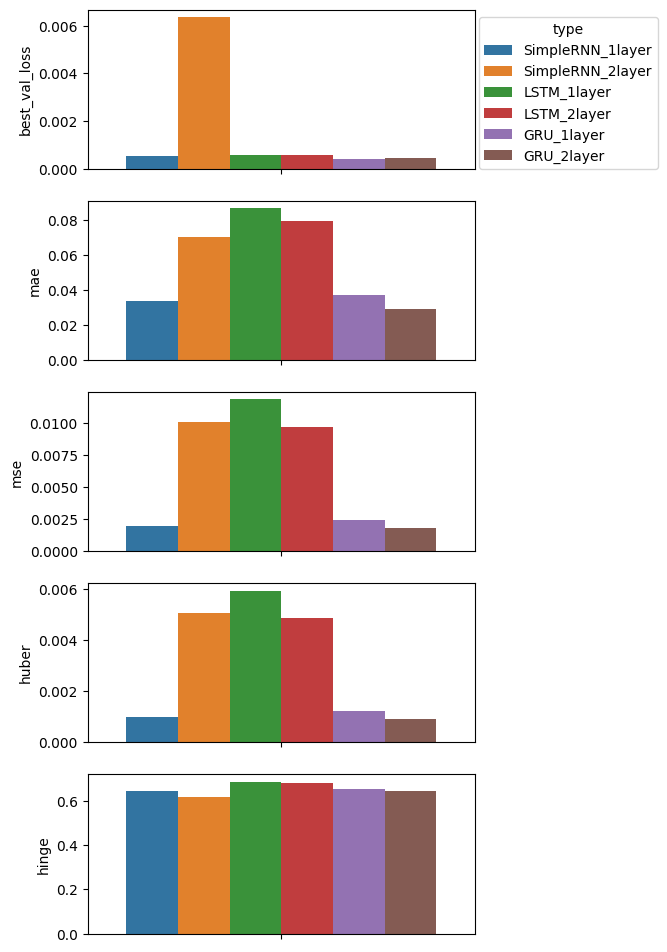

In [53]:
fig = plt.figure(figsize=(5,12))
axs = fig.subplots(nrows=5)
for i, col in enumerate(['best_val_loss', 'mae', 'mse', 'huber', 'hinge']):
    if i == 0:
        sns.move_legend(sns.barplot(res, hue='type', y=col, ax=axs[i], legend=True), (1.01,0))
    else:
        sns.barplot(res, hue='type', y=col, ax=axs[i], legend=False)

Gori rezultati u gotovo svim slucajevima, sem za simple RNN.
Odbacujemo i ovu transformaciju nadalje.